# Regression for Count Data

In [58]:
import os

# Change the current working directory
os.chdir('/Users/Sari/Documents/Code/Semester 4 workbooks')

In [89]:
# Import Necessary Libraries
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import multivariate_normal, bernoulli, beta, norm
from scipy.stats import ks_2samp
from scipy.special import expit as logistic_sigmoid
import statsmodels.api as sm
import statsmodels.formula.api as smf
from sklearn.datasets import load_iris
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import log_loss
from sklearn.metrics import brier_score_loss
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.metrics import balanced_accuracy_score, brier_score_loss, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import StandardScaler


# Set display option to avoid scientific notation in pandas, show up to 5 decimal points
pd.set_option('display.float_format', lambda x: '%.5f' % x)
# and numpy
np.set_printoptions(suppress=True, precision=5)

#### In this workbook we are going to build a model to predict the expected number of individuals killed from a terrorist attack. The occasion in which this would be used would be the moment a terrorism event would happen, a relevant intelligenece organisation might be tasked to generate an estimate for the expected severity of the event. 

#### When you replicate this workbook with your own data, I'd like to see evidence of you iterating over what model to use, which covariates to include and whether any interactions of non-linearities (e.g. including a squared term) should be included. Here we will use a very simple model which will not fit the data extremely well, but focus on interpretation of coefficients and choosing the correct `data generating process` (i.e. the correct likelihood function and / or transformation to apply to the data before fitting). 

### Part a): Load and clean data

In [60]:
# Load the clean terrorism dataset I've made available to you on canvas
df = pd.read_csv('clean_terror_data.csv',low_memory=False)

#### i. Explore the distribution of `nkill`, the number of people killed in a given terrorism incident. Specifically, plot a histogram of of the variable. What can you say about the distribution ? 

In [61]:
# Look at the first 1000 cases to get a tangible idea of what we are woking with
print(list(df["nkill"]))

[1.0, 0.0, 1.0, nan, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 7.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 47.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 2.0, 0.0, 1.0, 0.0, 0.0, 0.0, 0.0, nan, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

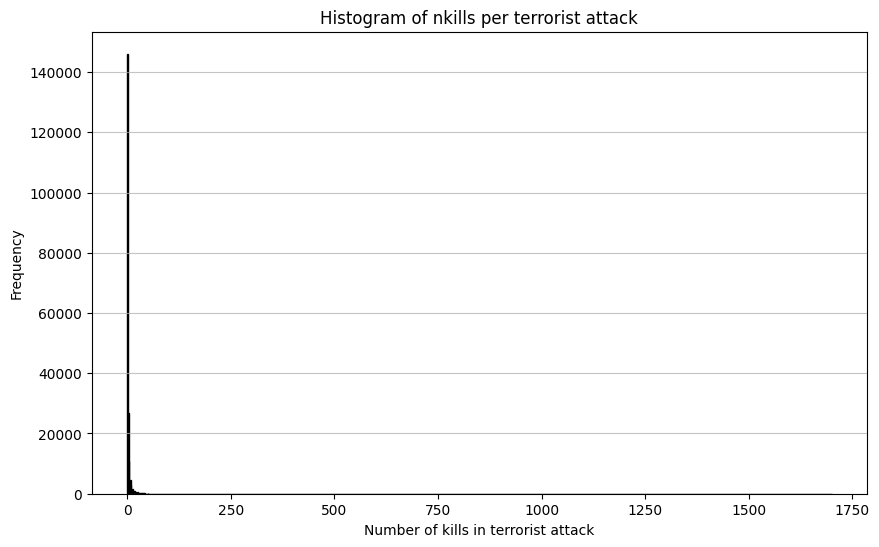

In [62]:
# Plot the histogram
plt.figure(figsize=(10, 6))
plt.hist(df["nkill"], bins=1000, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of nkills per terrorist attack")
plt.xlabel("Number of kills in terrorist attack")
plt.ylabel("Frequency")

plt.show()

##### Answer: 
1. The distribution is extremely skewed towards smaller values, seemingly 0. I.E. it isn't a normal distribution.

2. The relationship between frequency and nkill is non-linear.

#### ii. Take the log of nkill. Apply any necessary transformation to the data for this to work. What can you say about the resulting distribution ? 

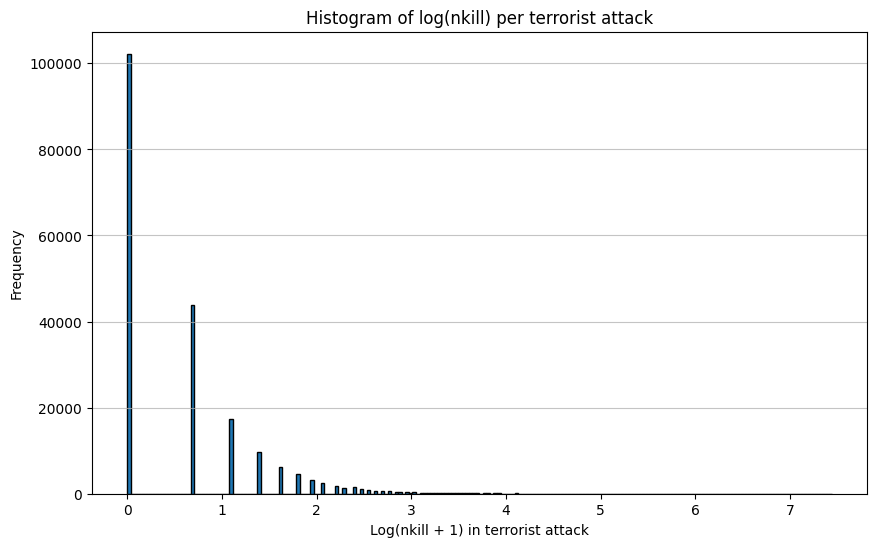

In [63]:
# log of 0 is undefined so I am adding 1 to our values
lognkill = np.log(df["nkill"] + 1)

plt.figure(figsize=(10, 6))
plt.hist(lognkill, bins=200, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Histogram of log(nkill) per terrorist attack")
plt.xlabel("Log(nkill + 1) in terrorist attack")
plt.ylabel("Frequency")

plt.show()

##### Answer: 

The X axis has been "squished", bigger values have been converted into much smaller values, we are a little bit closer to having a linear relationship between our X and our Y axes.

### Part b): Linear Regression

A naive approach to modeling this data may still be to use linear regression, and hence assume a normal distribution around the dependent variable. Note that, implicitly, assuming a normal around the dependent variable actually entails that your `residuals` -- so what is left of the variability in your dependent variable after netting the `systematic` component -- should be normally distributed:

$Y_i \sim N(mu_i, \sigma^2) \rightarrow (Y_i - mu_i) \sim N(0,\sigma^2)$

There are formal tests to see if your model's assumptions (here i. conditional independnce of each observation; ii. constant variance (homoskedasticity); iii. normality of errors; iv. linearity in parameters). The branch of statistics you are being taught does not obsess over these assumptions, and simply asks: `which model fits the data best ?`. So instead of testing assumptions we just fit different models and compare the `generalisation error`. In what follows for simplicity we compare models with in-sample performance, but this comparison of error metrics would be more effective / legitimate if applied to out-of-sample data. 

#### i. Select some variable which you should include in the model. Include `terrorist.org`.

In [64]:
# Let's create a cbrn variable (no nuclear in the sample (un?)fortunately )
df['weapon.type_cbrn'] = df['weapon.type_chemical'] +  df['weapon.type_biological'] +  df['weapon.type_radiological']  
df['nhostage'] = df['nhostage'].replace(np.NaN, 0)
# Assuming 'df' is your DataFrame containing the dataset
# Selecting relevant variables including the target variable
data = df[['nkill',
           'weapon.type_cbrn',
           'hostage',
           'nhostage'
        ]]
data

,nkill,weapon.type_cbrn,hostage,nhostage
0,1.00000,0,0.00000,0.00000
1,0.00000,0,1.00000,1.00000
2,1.00000,0,0.00000,0.00000
3,NaN,0,0.00000,0.00000
4,NaN,0,0.00000,0.00000
...,...,...,...,...
217348,1.00000,0,1.00000,1.00000
217349,0.00000,0,1.00000,1.00000
217350,0.00000,0,0.00000,0.00000
217351,0.00000,0,0.00000,0.00000


#### ii. Pick some terrorist organisations to include in the model. One option isidentify the 10 (?) most frequent, group all those outside this group into a new class `other`. Make sure you edit the `terrorist.org` variable to reflect this. 

In [65]:
# identify the most common orgs (you should have some code before this that allows you to identify these by frequency or otherwise)
n_most_frequent = 10
most_common_orgs = df['terrorist.org'].value_counts()[:n_most_frequent].index.tolist()

# Modify the df['terrorist.org'] column
# Check if each value is in the most_common_orgs list, otherwise replace it with 'other'
df['terrorist.org'] = df['terrorist.org'].apply(lambda org: org if org in most_common_orgs else 'other')
terrorist_org_dummies = pd.get_dummies(df["terrorist.org"])
terrorist_org_dummies = terrorist_org_dummies.drop("Taliban", axis=1)
terrorist_org_dummies = terrorist_org_dummies.astype(int)

#### iii. Now create your design matrix and you dependent variable vector. Ensure you include terrorist.org, one-hot encode it and drop the first (most frequent) org (the Taliban). This will serve as your reference. Drop incomplete records. To ensure a successful model fit, drop columns that have 0 variance and those which exhibit multicollinearity. Standardise your covariates. 

In [74]:
# Select predictors and target variable before dropping missing values
X = df[[
    'nkill',
    'weapon.type_cbrn',
    'hostage',
    'nhostage',
    'terrorist.org'
    ]]

# Drop rows with missing values in any selected variable or the target
data_cleaned = X.dropna()

# Separate predictors and target variable after cleaning
y_cleaned = data_cleaned['nkill']
y_log_cleaned = np.log(data_cleaned['nkill']+1)
X_cleaned = data_cleaned.drop(columns=['nkill'])



,weapon.type_cbrn,hostage,nhostage,terrorist.org
0,0,0.00000,0.00000,other
1,0,1.00000,1.00000,other
2,0,0.00000,0.00000,Unknown
5,0,0.00000,0.00000,other
6,0,0.00000,0.00000,other
...,...,...,...,...
217348,0,1.00000,1.00000,Unknown
217349,0,1.00000,1.00000,Boko Haram
217350,0,0.00000,0.00000,other
217351,0,0.00000,0.00000,Unknown


In [81]:
# One-hot encoding categorical variables and dropping the first dummy to avoid multicollinearity
X_encoded = pd.get_dummies(X_cleaned).drop("terrorist.org_Taliban", axis=1).astype(int)


In [82]:
# Drop variables with 0 variability (no information) (I will do this for you because you haven't used this before)

# VarianceThreshold with a threshold of 0 (default) to remove 0 variance columns
selector = VarianceThreshold()
X_encoded_var_filtered = selector.fit_transform(X_encoded)
# Get the columns after variance thresholding
X_encoded_var_filtered = X_encoded.iloc[:, selector.get_support(indices=True)]

In [83]:
# Calculate the correlation matrix (absolute value - we don't care about direction of correlation)
corr_matrix = abs(X_encoded.corr())

# Select upper triangle of correlation matrix
# what is this?
# my guess: something to do with highly correlated coefficients
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Initialize an empty list to keep track of columns to drop
to_drop = []

# Iterate over the columns of the upper triangle
for column in upper_tri.columns:
    for row in upper_tri.index:
        # Check if the correlation is above the threshold and the column hasn't been considered yet
        if upper_tri.loc[row, column] > 0.9 and column not in to_drop and row not in to_drop:
            to_drop.append(column)
            break  # Break the loop once a column is marked for dropping

# 'to_drop' contains columns where only one of each highly correlated pair is considered for dropping

In [85]:
# Drop highly correlated features 
X_encoded_final = X_encoded_var_filtered.drop(columns=to_drop)

In [86]:
# Standardise features to help with interpretation (Again I will do this for you because you haven't seen this before.)

# Initialize the StandardScaler
scaler = StandardScaler()

# Fit on training set only
scaler.fit(X_encoded_final)

# Apply transform to both the training set and the test set
X_train_scaled = pd.DataFrame(scaler.transform(X_encoded_final), columns=X_encoded_final.columns, index=X_encoded_final.index)

#### iv. Fit a linear regression model to the data. Print the summary and a histogram of the residuals. Is it normally distributed ? 

In [94]:
# Adding a constant for the intercept
X_encoded_with_const = sm.add_constant(X_train_scaled)

,const,weapon.type_cbrn,hostage,nhostage,terrorist.org_Al-Shabaab,terrorist.org_Boko Haram,terrorist.org_Farabundo Marti National Liberation Front (FMLN),terrorist.org_Houthi extremists (Ansar Allah),terrorist.org_Irish Republican Army (IRA),terrorist.org_Islamic State of Iraq and the Levant (ISIL),terrorist.org_New People's Army (NPA),terrorist.org_Shining Path (SL),terrorist.org_Unknown,terrorist.org_other
0,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,1.34523
1,1.00000,-0.04730,3.74281,0.01457,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,1.34523
2,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,1.12384,-0.74337
5,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,1.34523
6,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,1.34523
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
217348,1.00000,-0.04730,3.74281,0.01457,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,1.12384,-0.74337
217349,1.00000,-0.04730,3.74281,0.01457,-0.13593,8.10914,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,-0.74337
217350,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,-0.88980,1.34523
217351,1.00000,-0.04730,-0.26718,-0.03103,-0.13593,-0.12332,-0.11299,-0.11808,-0.11207,-0.18662,-0.12915,-0.14325,1.12384,-0.74337


In [121]:
from IPython.core.display import display, HTML
# This should help you visualise all your coefficients if you have many
display(HTML("<style>.container { width:90% !important; }</style>"))

# making our Y a dataframe
y_log_cleaned = pd.DataFrame(y_log_cleaned)

# Fitting the linear regression model
model = sm.OLS(y_log_cleaned, X_encoded_with_const).fit()

# Displaying the regression results
print(model.summary())

/var/folders/25/82ztpk21087b258r7gs0n3m00000gn/T/ipykernel_38742/3835026495.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:                  nkill   R-squared:                       0.080
Model:                            OLS   Adj. R-squared:                  0.080
Method:                 Least Squares   F-statistic:                     1355.
Date:                Fri, 08 Mar 2024   Prob (F-statistic):               0.00
Time:                        13:58:57   Log-Likelihood:            -2.4803e+05
No. Observations:              203412   AIC:                         4.961e+05
Df Residuals:                  203398   BIC:                         4.962e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

Text(0, 0.5, 'Frequency')

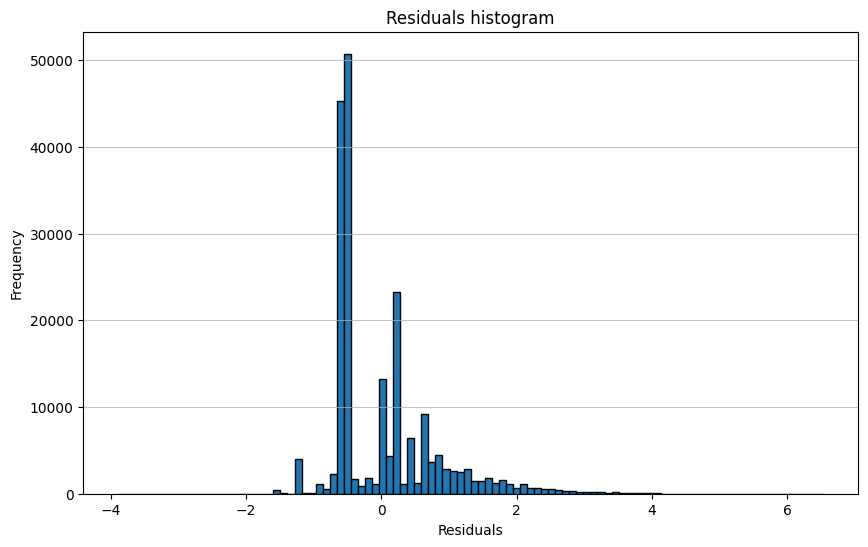

In [125]:
# Plotting histogram of residuals
residuals = model.resid
plt.figure(figsize=(10, 6))
plt.hist(residuals, bins=100, edgecolor='black')
plt.grid(axis='y', alpha=0.75)
plt.title("Residuals histogram")
plt.xlabel("Residuals")
plt.ylabel("Frequency")

#### v. Simulate 1000 values from the joint posterior distribution of the regression coefficients. 

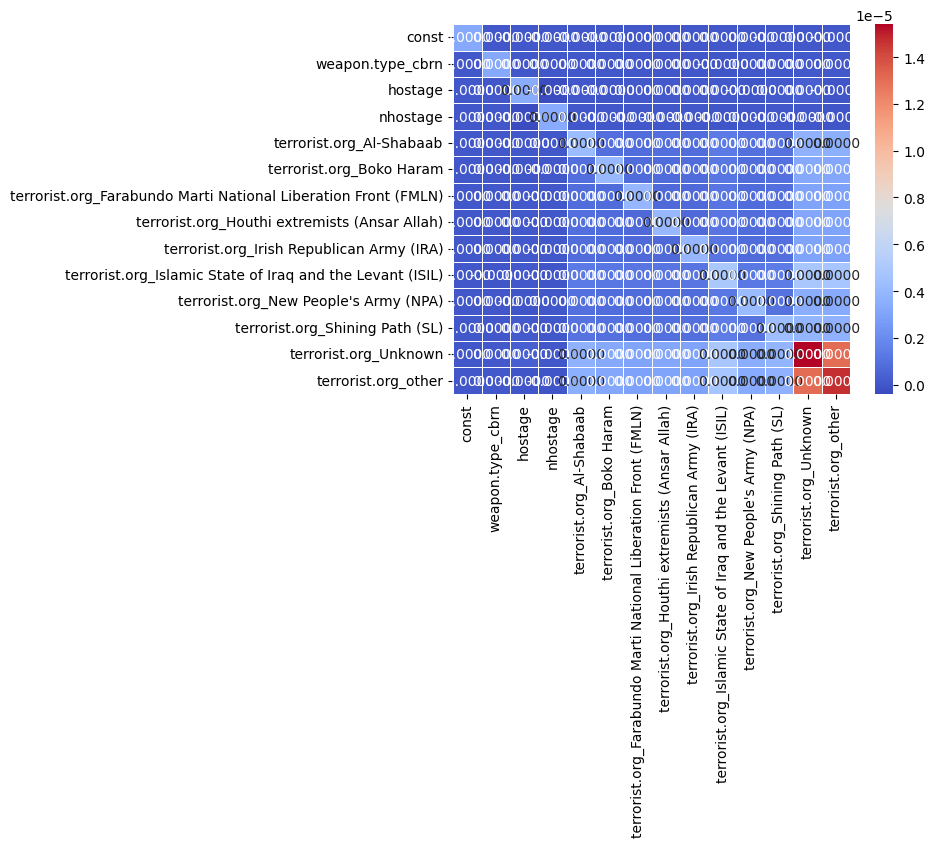

In [130]:
import seaborn as sns

# extract regression coefficients and covariance matrix
params = model.params
cov_matrix = model.cov_params()
sns.heatmap(cov_matrix, annot=True, cmap='coolwarm', fmt=".4f", linewidths=.5)
# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

#### vi. Use a `violin plot` to display the distrubution and point-estimates of the most `statistically significant` coefficients. To pick the most significant coefficients, you can use a rule of thumb as harsh as Pr(beta>0)>0.975 | Pr(beta>0)<0.025, or as laxed as Pr(beta>0)>0.8 | Pr(beta>0)<0.2.

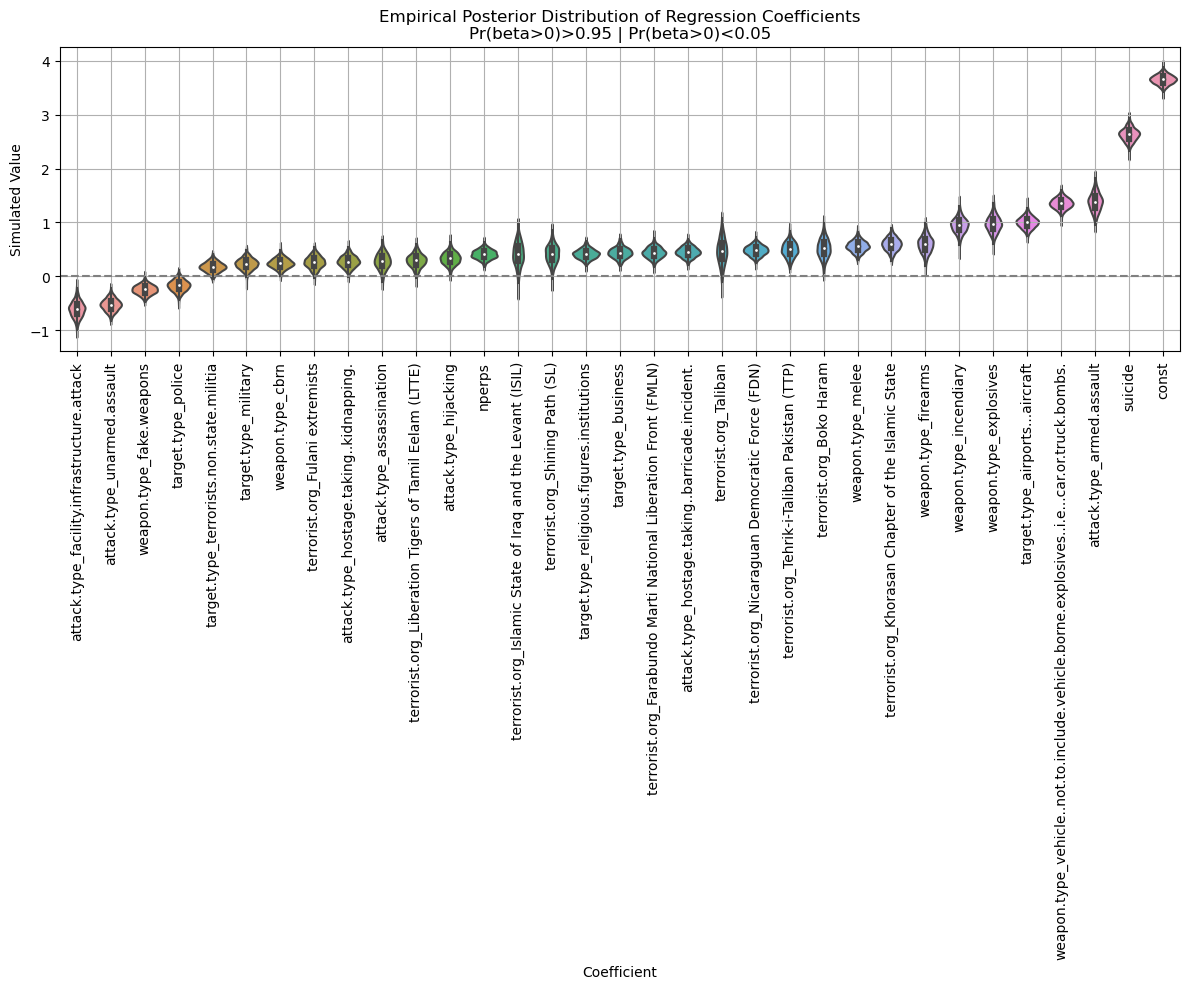

In [ ]:
# # # I will do this for you on this instance, you have to repeat it for the following regressions. 

# Transform simulated_betas into a DataFrame for plotting
simulations_df = pd.DataFrame(simulated_betas, columns=model.params.index)

# Convert the DataFrame from wide to long format
long_df = simulations_df.melt(var_name='Coefficient', value_name='Value')

# Calculate the probability of coef > 0 for each coefficient
prob_greater_than_zero = long_df.groupby('Coefficient')['Value'].apply(lambda x: np.mean(x > 0)).reset_index()
prob_greater_than_zero.rename(columns={'Value': 'P(coef>0)'}, inplace=True)

# Filter coefficients based on the probability criterion
filtered_coefs = prob_greater_than_zero[
    (prob_greater_than_zero['P(coef>0)'] > 0.95) | (prob_greater_than_zero['P(coef>0)'] < 0.05)
]['Coefficient']

# Filter the long_df to include only the selected coefficients
filtered_long_df = long_df[long_df['Coefficient'].isin(filtered_coefs)]

# Calculate the median of the simulated values for each filtered coefficient
medians = filtered_long_df.groupby('Coefficient')['Value'].median().reset_index()

# Sort the filtered medians
medians_sorted = medians.sort_values(by='Value')

# Plotting the filtered and ordered coefficients
plt.figure(figsize=(12, 10))  # Adjust the figure size as needed
sns.violinplot(x='Coefficient', y='Value', data=filtered_long_df, order=medians_sorted['Coefficient'])

# Add a vertical dotted line at x = 0
plt.axhline(y=0, color='grey', linestyle='--')

# Additional customization
plt.title('Empirical Posterior Distribution of Regression Coefficients\nPr(beta>0)>0.95 | Pr(beta>0)<0.05')
plt.xticks(rotation=90)  # Rotate the x-axis labels for better readability
plt.xlabel('Coefficient')
plt.ylabel('Simulated Value')
plt.grid(True)

# Display the plot
plt.tight_layout()  # Adjust layout to not cut off labels
plt.show()

#### vii. Draw 1000 samples from the posterior predictive distribution of $y$. 

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = np.zeros((n_simulations, X_encoded_with_const.shape[0]))

# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation =...
    predicted_rate = ...
    predicted_counts[i] = np.random.normal(predicted_rate,np.sqrt(model.scale))

#### viii. Calculate the monte-carlo medians and prediction intervals. Based on these, calculate the point estimate correlation, rmse, bias and coverage. 

In [ ]:
# Hint: Look back at your 1st workshop on linear regression
monte_carlo_medians = np.median(...)
prediction_intervals = np.percentile(...)


# Calculate metrics
correlation = np.corrcoef(...)[0, 1]
rmse = np.sqrt(mean_squared_error(...))
bias = np.mean(...)  # Mean prediction error
coverage = np.mean((...) & (...))

#### ix. Plot the predicted values against the observed values of $y$. Display the error metrics above in the legend. 

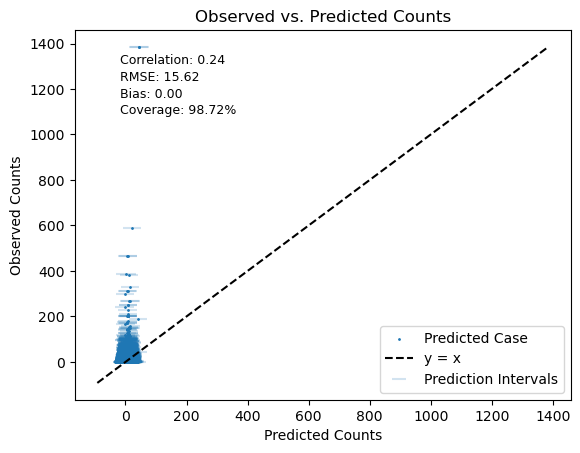

In [ ]:
# # # I'll do this one for you...

# Find overall min and max for xlim and ylim
# Flatten predicted_samples to make it 1-dimensional
predicted_counts_flat = predicted_counts.flatten()
# Concatenate the flattened predicted_samples with y
combined_array = np.concatenate([predicted_counts_flat, y_cleaned])


# calculate min and max
min_val = combined_array.min()
max_val = combined_array.max()

# Plotting
scatter = plt.scatter(monte_carlo_medians, y_cleaned, s=1, alpha=1, label='Predicted Case')
errorbar = plt.errorbar(monte_carlo_medians, y_cleaned, xerr=np.abs(prediction_intervals - monte_carlo_medians), fmt='none', alpha=0.2, label='Prediction Intervals')
y_equals_x = plt.plot([min_val, max_val], [min_val, max_val], 'k--', zorder=3, label='y = x')

# Add legend with metrics
legend_labels = [
    f'Correlation: {correlation:.2f}',
    f'RMSE: {rmse:.2f}',
    f'Bias: {bias:.2f}',
    f'Coverage: {coverage:.2%}'
]

# Add legend for plot elements
plt.legend(loc='lower right')

# Text annotations for metrics
text_x = min_val + (max_val - min_val) * 0.05  # Adjust these positions as necessary
text_y_start = max_val - (max_val - min_val) * 0.05  # Starting y position for text
line_height = (max_val - min_val) * 0.05  # Adjust line height as necessary

for i, label in enumerate(legend_labels):
    plt.text(text_x, text_y_start - i * line_height, label, fontsize=9)

plt.title('Observed vs. Predicted Counts')
plt.xlabel('Predicted Counts')
plt.ylabel('Observed Counts')
plt.show()


### Part c): Log-Linear Regression

Repeat the above from the model fitting onwards, but change the dependent variable to be on the log-scale. Apply any transformation you see fit to achieve this. 

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

...

/var/folders/fn/dxhdxm5j4wd83g41k0wj1wd80000gn/T/ipykernel_96862/598896821.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                            OLS Regression Results                            
Dep. Variable:                  nkill   R-squared:                       0.323
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     244.3
Date:                Mon, 04 Mar 2024   Prob (F-statistic):               0.00
Time:                        14:46:12   Log-Likelihood:                -38057.
No. Observations:               32775   AIC:                         7.624e+04
Df Residuals:                   32710   BIC:                         7.679e+04
Df Model:                          64                                         
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------

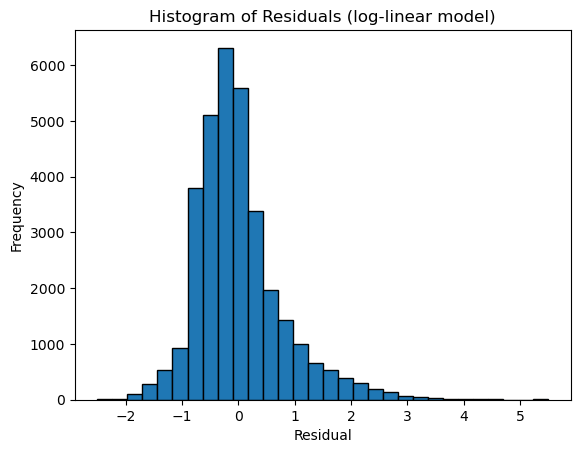

In [ ]:
# Plotting histogram of residuals
...

In [ ]:
# extract regression coefficients and covariance matrix
...

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

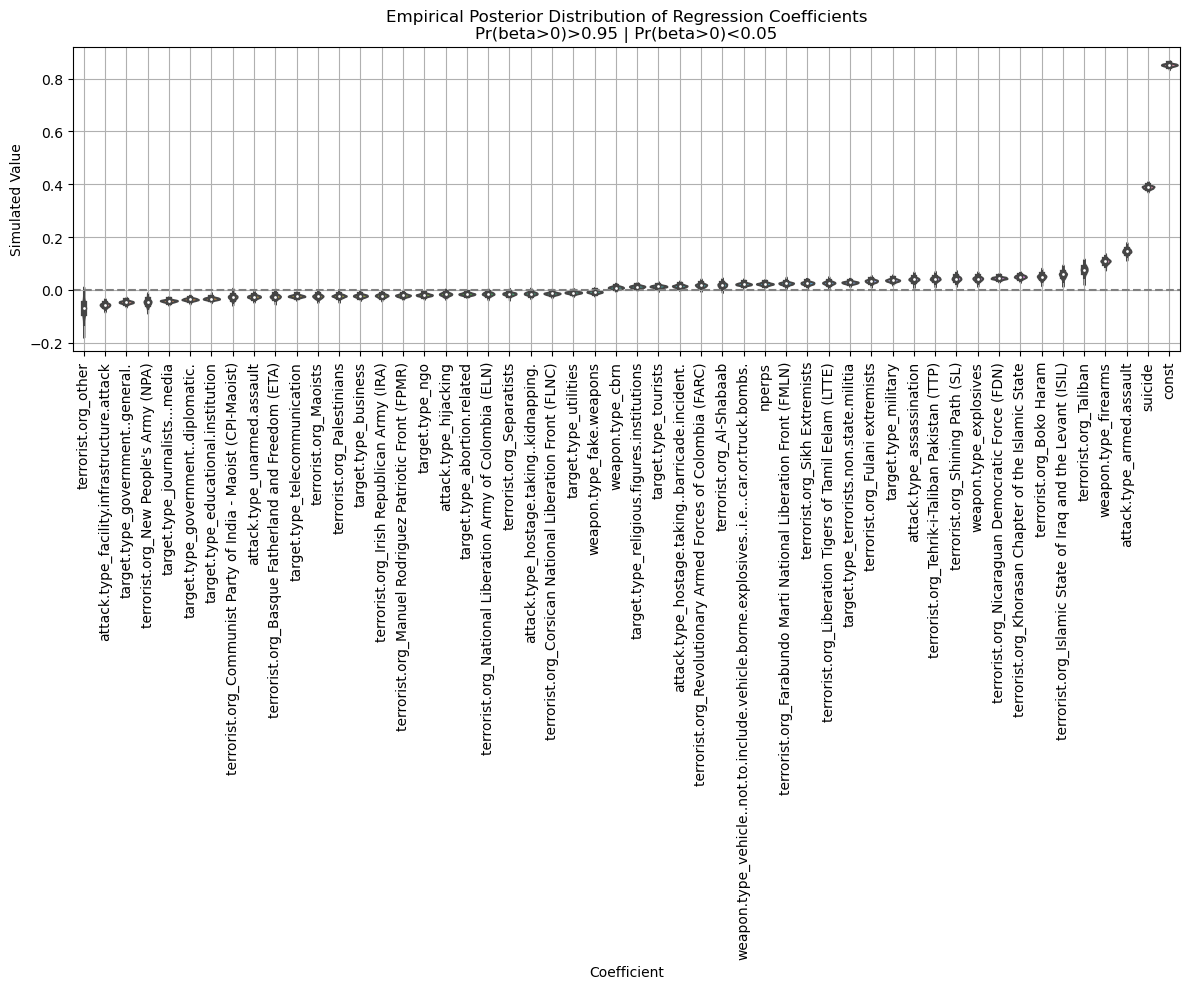

In [ ]:
# Violin Plot
...

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = ...

In [ ]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_log_rate = np.dot(X_encoded_with_const, beta_simulation)
    # Simulate from the posterior-predictive distirbution 
    predicted_counts[i] = np.exp(...)

In [ ]:
monte_carlo_medians = np.median(...)
prediction_intervals = np.percentile(...)

# Calculate metrics
...

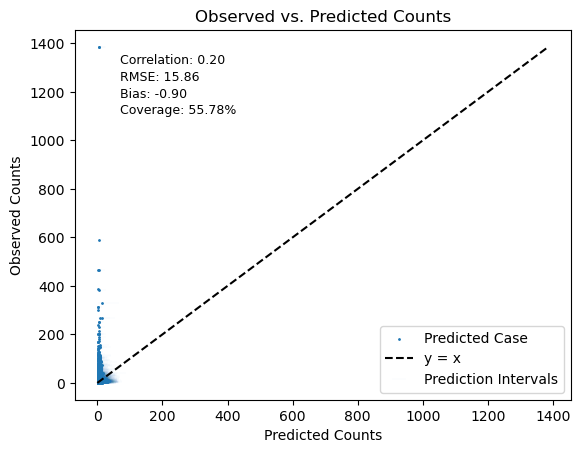

In [ ]:
# Plot Predictions v. Observations
...

### Part d): Poisson Regression

Repeat the above from the model fitting onwards, but change the distribution of the depedent variable from normal to Poisson. You can fit a poisson regression using the GLM module of the statsmodels library. Comment on which of the three regression models is most useful for this application and why. 

In [ ]:
from statsmodels.api import GLM, Poisson

In [ ]:
from IPython.core.display import display, HTML

display(HTML("<style>.container { width:90% !important; }</style>"))

# Fitting the linear regression model
model = sm.GLM(... family=sm.families.Poisson()).fit()

# Displaying the regression results
print(model.summary())

/var/folders/fn/dxhdxm5j4wd83g41k0wj1wd80000gn/T/ipykernel_96862/453724424.py:1: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython display
  from IPython.core.display import display, HTML


                 Generalized Linear Model Regression Results                  
Dep. Variable:                  nkill   No. Observations:                32775
Model:                            GLM   Df Residuals:                    32710
Model Family:                 Poisson   Df Model:                           64
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -1.5821e+05
Date:                Mon, 04 Mar 2024   Deviance:                   2.5765e+05
Time:                        14:46:21   Pearson chi2:                 9.32e+05
No. Iterations:                    17   Pseudo R-squ. (CS):             0.9670
Covariance Type:            nonrobust                                         
                                                                                              coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------

In [ ]:
# extract regression coefficients and covariance matrix
...

# Number of simulations
n_simulations = 1000

# Simulate beta coefficients
simulated_betas = ...

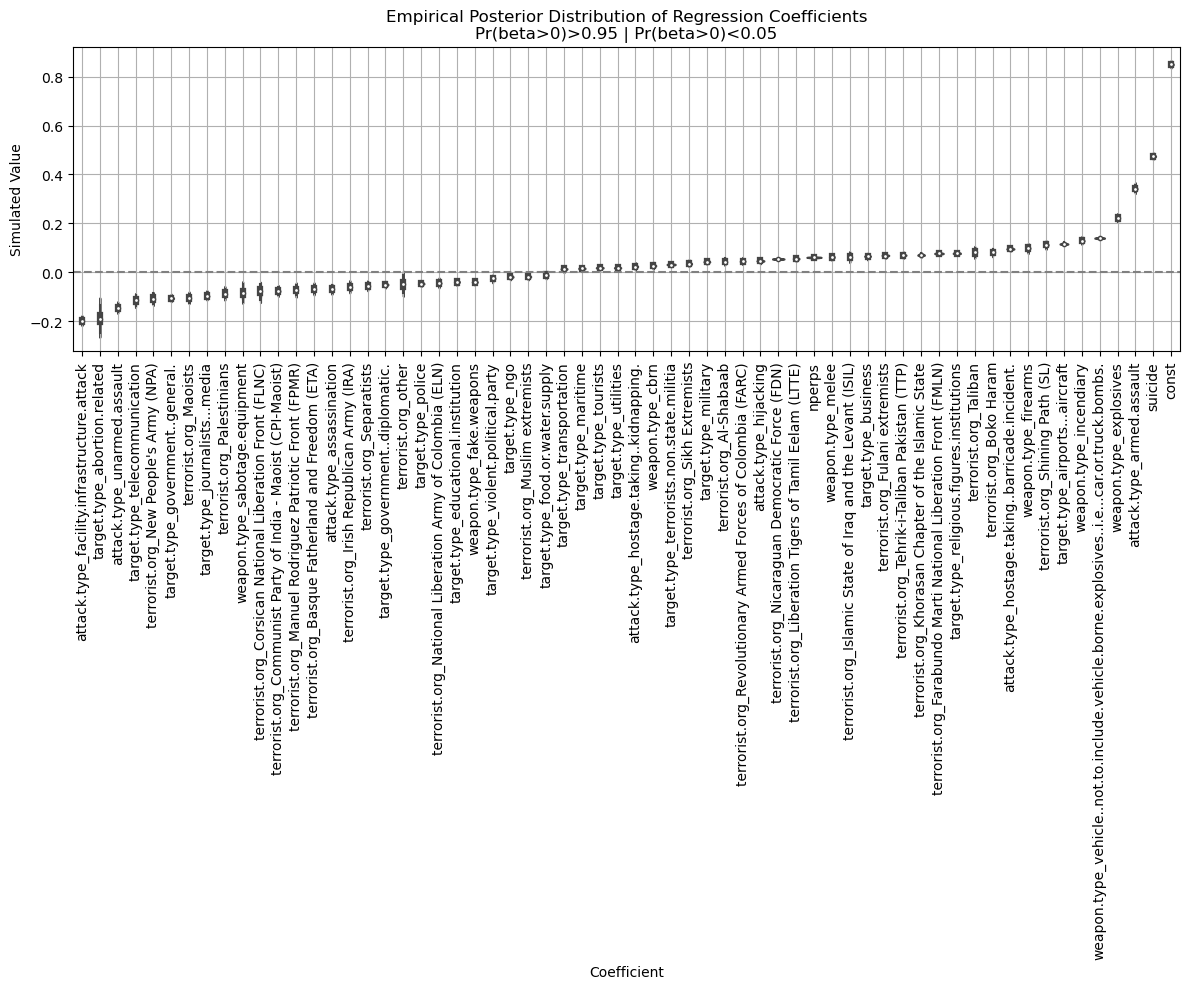

In [ ]:
# Violin Plot
...

In [ ]:
# Initialize an array to store predictions from each simulation
predicted_counts = ...

In [ ]:
# Generate predictions for each simulation
for i in range(n_simulations):
    beta_simulation = simulated_betas[i]
    predicted_rate = np.exp(np.dot(X_encoded_with_const, beta_simulation))
    predicted_counts[i] = np.random.poisson(predicted_rate)

In [ ]:
...

# Calculate metrics
...

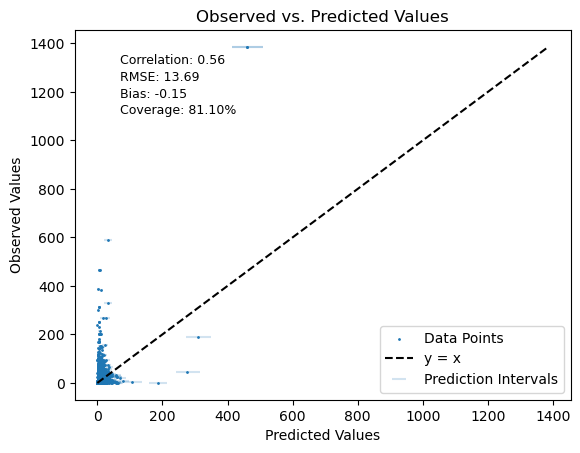

In [ ]:
# Plot Predictions v. Observations

##### Answer: 

...